## Q2: Traffic Sign Detection

### Preparing Dataset

In [1]:
import requests, zipfile
from io import StringIO
import tensorflow as tf

In [ ]:
# do not run this unless you want to download and extract 1.5 gb of data
# this could take a while!
try:
    url="https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip"
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO(r.content))
    z.extractall("./data/FullIJCNN2013")
except:
    print("folder already exists!")

In [2]:
id_to_lable={0: "speed limit 20 (prohibitory)",
            1: "speed limit 30 (prohibitory)",
            2: "speed limit 50 (prohibitory)",
            3: "speed limit 60 (prohibitory)",
            4: "speed limit 70 (prohibitory)",
            5: "speed limit 80 (prohibitory)",
            6: "restriction ends 80 (other)",
            7: "speed limit 100 (prohibitory)",
            8: "speed limit 120 (prohibitory)",
            9: "no overtaking (prohibitory)",
            10: "no overtaking (trucks), (prohibitory)",
            11: "priority at next intersection (danger)",
            12: "priority road (other)",
            13: "give way (other)",
            14: "stop (other)",
            15: "no traffic both ways (prohibitory)",
            16: "no trucks (prohibitory)",
            17: "no entry (other)",
            18: "danger (danger)",
            19: "bend left (danger)",
            20: "bend right (danger)",
            21: "bend (danger)",
            22: "uneven road (danger)",
            23: "slippery road (danger)",
            24: "road narrows (danger)",
            25: "construction (danger)",
            26: "traffic signal (danger)",
            27: "pedestrian crossing (danger)",
            28: "school crossing (danger)",
            29: "cycles crossing (danger)",
            30: "snow (danger)",
            31: "animals (danger)",
            32: "restriction ends (other)",
            33: "go right (mandatory)",
            34: "go left (mandatory)",
            35: "go straight (mandatory)",
            36: "go right or straight (mandatory)",
            37: "go left or straight (mandatory)",
            38: "keep right (mandatory)",
            39: "keep left (mandatory)",
            40: "roundabout (mandatory)",
            41: "restriction ends (overtaking), (other)",
            42: "restriction ends (overtaking (trucks),), (other)"}

In [3]:
file= open("./data/FullIJCNN2013/gt.txt")
annotations={}
for f in file:
    line=f.split(';')
    if line[0] not in annotations.keys():
        annotations[line[0]]=[]
    annotations[line[0]].append([int(line[1]),int(line[2]),int(line[3]),int(line[4]),int(line[5])])

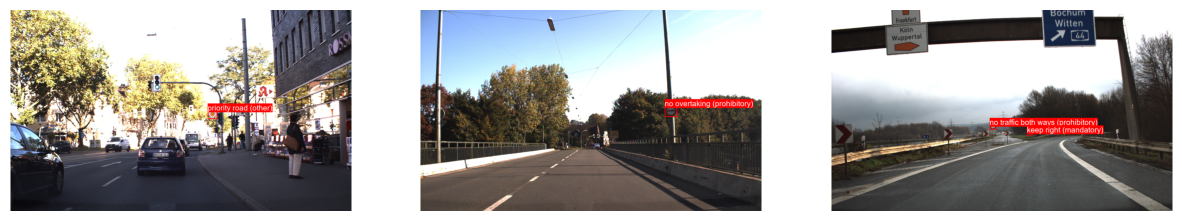

In [5]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random, os
import numpy as np

def load_and_convert_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".ppm"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            tensor_img = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
            images.append(tensor_img)
    return images

images = load_and_convert_images("./data/FullIJCNN2013/")

def draw_annotations_on_image(img_idx, images, annotations):
    image = Image.fromarray((images[img_idx].numpy()).astype(np.uint8))
    draw = ImageDraw.Draw(image)

    if str(img_idx).zfill(5)+'.ppm' not in annotations.keys(): # no anotations
        return image

    for annotation in annotations[str(img_idx).zfill(5)+'.ppm']:
        rectangle_coords = (annotation[0], annotation[1], annotation[2], annotation[3])

        draw.rectangle(rectangle_coords, outline="red", width=3)

        text = id_to_lable[annotation[4]]
        text_position = (rectangle_coords[0], rectangle_coords[1] - 20)
        font = ImageFont.truetype("arial.ttf", 30)
        _, _, width, height = draw.textbbox((0, 0), text=text, font=font)
        background_coords = (text_position[0], text_position[1], text_position[0] + width, text_position[1] + height)
        draw.rectangle(background_coords, fill="red")
        draw.text(text_position, text, fill="white", font=font)

    return image

num_images=3
random_selected = [draw_annotations_on_image(random.randint(0, len(images)), images, annotations) for _ in range(num_images)]

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for ax, img in zip(axes, random_selected):
    ax.imshow(img)
    ax.axis('off')

plt.show()
del images

In [6]:
size_label={0:'small',
               1: 'medium',
               2: 'large'}

def width_to_size_label(width):
    if width < 32:
        return size_label[0]
    elif width < 45:
        return size_label[1]
    return size_label[2]

In [7]:
size_label_count={'small':0, 'medium':0, 'large':0}
for v in annotations.values():
    for coords in v:
        size_label_count[width_to_size_label(np.abs(coords[0]-coords[2]))]+=1
print(size_label_count)

{'small': 413, 'medium': 366, 'large': 434}


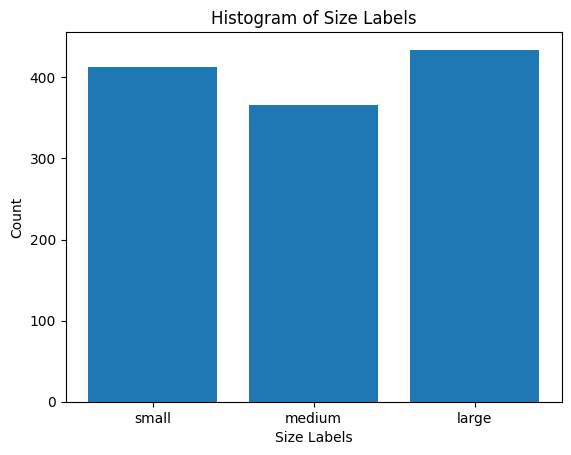

In [ ]:
import matplotlib.pyplot as plt

labels = list(size_label_count.keys())
counts = list(size_label_count.values())

plt.bar(labels, counts)
plt.xlabel('Size Labels')
plt.ylabel('Count')
plt.title('Histogram of Size Labels')
plt.show()

In [8]:
labels_classified={'prohibitory':0, 'danger':0, 'mandatory':0, 'other':0}
for v in annotations.values():
    for coords in v:
        for label in labels_classified.keys():
            if (label in id_to_lable[coords[4]]):
                labels_classified[label]+=1
print(labels_classified)

{'prohibitory': 557, 'danger': 219, 'mandatory': 163, 'other': 274}


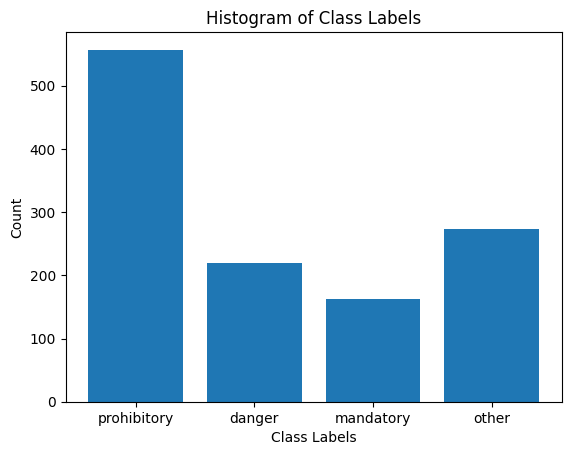

In [ ]:
import matplotlib.pyplot as plt

labels = list(labels_classified.keys())
counts = list(labels_classified.values())

plt.bar(labels, counts)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Histogram of Class Labels')
plt.show()

## data prepration
run on colab

In [ ]:
from io import BytesIO
import requests
import zipfile

url="https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip"
r = requests.get(url, stream=True)
z = zipfile.ZipFile(BytesIO(r.content))
z.extractall("./data/")

## 2 stage model

In [10]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset
from torchvision import transforms

class MyDataset(Dataset):
    def __init__(self, annotations_file, img_dir):
        labels_classified={'prohibitory':0, 'danger':1, 'mandatory':2, 'other':3}

        self.img_labels = pd.read_csv(annotations_file)
        for i in range(len(self.img_labels['class'])):
            for label in labels_classified.keys():
                if (label in id_to_lable[self.img_labels['class'][i]]):
                    self.img_labels['class'][i] = labels_classified[label]

        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_labels)

    def transform(self, image):
        data_transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Resize([100, 100]),
        ])
        image = data_transform(image)

        mean = image.mean(dim=[1, 2])
        std = image.std(dim=[1, 2])

        norm_transform = transforms.Compose([
            transforms.Normalize(mean.tolist(), std.tolist()),
        ])

        image = norm_transform(image)
        return image

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"imgae: {img_path} not found!")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)

        boxes = self.img_labels.iloc[idx, 1:5].values
        boxes = np.array([boxes], dtype=np.float32)

        labels = torch.tensor([self.img_labels.iloc[idx, 5]], dtype=torch.int64)

        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = labels

        return image, target


In [21]:
import torch
from torch.utils.data import DataLoader, random_split

dataset = MyDataset(annotations_file='./gt.csv', img_dir='./data/FullIJCNN2013/')

train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
del dataset

def collate_fn(batch): #for pickle
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

C:\Users\arian\AppData\Local\Temp\ipykernel_3484\2162076141.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.img_labels['class'][i] = labels_classified[label]
C:\Users\arian\AppData\Local\Temp\ipykernel_3484\2162076141.py:17: Settin

Train set size: 970
Test set size: 243


C:\Users\arian\AppData\Local\Temp\ipykernel_3484\2162076141.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.img_labels['class'][i] = labels_classified[label]
C:\Users\arian\AppData\Local\Temp\ipykernel_3484\2162076141.py:17: Settin

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
faster_rcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
faster_rcnn_model.to(device)

optimizer = torch.optim.Adam(faster_rcnn_model.parameters(), lr=0.0001)
num_epochs = 10

for epoch in range(num_epochs):
    faster_rcnn_model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = faster_rcnn_model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        print('.', end='')

    print(f'epoch: {epoch + 1}, loss: {epoch_loss}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


..........................................................................................................................epoch: 1, loss: 13.538211065344512
..........................................................................................................................epoch: 2, loss: 7.524772785604


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


..........................................................................................................................epoch: 3, loss: 5.861640771385282
..........................................................................................................................epoch: 4, loss: 5.204536926117726
..........................................................................................................................epoch: 5, loss: 4.625732455111574
..........................................................................................................................epoch: 6, loss: 4.66502833267441
..........................................................................................................................epoch: 7, loss: 4.778999374946579
..........................................................................................................................epoch: 8, loss: 4.129782423842698
.................................................................

In [ ]:
torch.save(faster_rcnn_model.state_dict(), 'fasterrcnn_model.pth')

## 1 Stage model

In [ ]:
from torchvision.models.detection.ssd import SSD300_VGG16_Weights
from torchvision.models.detection import ssd300_vgg16

weights = SSD300_VGG16_Weights.DEFAULT
vgg16_model = ssd300_vgg16(weights=weights)
vgg16_model.head.classification_head.num_classes = 5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
vgg16_model.to(device)

optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=0.0001)
num_epochs = 20

for epoch in range(num_epochs):
    vgg16_model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = vgg16_model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        print('.', end='')

    print(f'epoch: {epoch + 1}, loss: {epoch_loss}')

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 157MB/s]


..........................................................................................................................epoch: 1, loss: 432.9750012308359
..........................................................................................................................epoch: 2, loss: 260.46081767976284
..........................................................................................................................epoch: 3, loss: 237.83508524298668
..........................................................................................................................epoch: 4, loss: 211.11180245503783
..........................................................................................................................epoch: 5, loss: 193.20211277157068
..........................................................................................................................epoch: 6, loss: 181.49251729995012
...........................................................

In [ ]:
for epoch in range(num_epochs):
    vgg16_model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = vgg16_model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        print('.', end='')

    print(f'epoch: {epoch + 1}, loss: {epoch_loss}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


..........................................................................................................................epoch: 1, loss: 89.78119803220034
..........................................................................................................................epoch: 2, loss: 88.60503894090652
..........................................................................................................................epoch: 3, loss: 83.3247685637325
..........................................................................................................................epoch: 4, loss: 77.234548792243
..........................................................................................................................epoch: 5, loss: 75.17161168158054
..........................................................................................................................epoch: 6, loss: 73.96681146323681
...................................................................

In [ ]:
torch.save(vgg16_model.state_dict(), 'vgg16_model.pth')

## results

In [12]:
from torchvision.ops import box_iou

def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

def compute_ap(ious, preds_sorted_idx, iou_threshold=0.5):
    true_positives = []
    false_positives = []

    for idx in preds_sorted_idx:
        iou = ious[idx]
        if iou >= iou_threshold:
            true_positives.append(1)
            false_positives.append(0)
        else:
            true_positives.append(0)
            false_positives.append(1)

    tp_cumsum = torch.cumsum(torch.tensor(true_positives), dim=0)
    fp_cumsum = torch.cumsum(torch.tensor(false_positives), dim=0)

    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)  # Added small value to avoid division by zero
    recalls = tp_cumsum / (len(preds_sorted_idx) + 1e-6)

    return torch.mean(precisions).item()

def evaluate_model(model, data_loader, device):
    model.eval()
    aps = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].cpu()
                pred_scores = output['scores'].cpu()
                true_boxes = target['boxes'].cpu()

                if len(true_boxes) == 0:
                    continue

                ious = box_iou(pred_boxes, true_boxes)
                if ious.numel() == 0:
                    continue

                preds_sorted_idx = pred_scores.sort(descending=True).indices
                ap = compute_ap(ious, preds_sorted_idx)
                aps.append(ap)

    if len(aps) == 0:
        return 0.0

    mean_ap = sum(aps) / len(aps)
    return mean_ap, aps

Loading From Trained Models, only run locally

In [17]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.ssd import ssd300_vgg16, SSD300_VGG16_Weights

trained_faster_rcnn = fasterrcnn_resnet50_fpn(weights=None)
in_features = trained_faster_rcnn.roi_heads.box_predictor.cls_score.in_features
trained_faster_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, 5)
trained_faster_rcnn.load_state_dict(torch.load('./models/fasterrcnn_model.pth', map_location=torch.device('cpu')))
trained_faster_rcnn.eval()

trained_vgg16 = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
trained_vgg16.head.classification_head.num_classes = 5
trained_vgg16.load_state_dict(torch.load('./models/vgg16_model.pth', map_location=torch.device('cpu')))
trained_vgg16.eval()
print('this output is for jupyter to not show eval result in cell output')

C:\Users\arian\AppData\Local\Temp\ipykernel_3484\2811508806.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_faster_rcnn.load_state_dict(torch.load('./models/fast

this output is for jupyter to not show eval result in cell output


C:\Users\arian\AppData\Local\Temp\ipykernel_3484\2811508806.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_vgg16.load_state_dict(torch.load('./models/vgg16_mod

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
mean_ap, aps = evaluate_model(trained_faster_rcnn, test_loader, device)
print(f"map: {mean_ap}")
print(f"APS: {aps}")

map: 0.5770819511144392
APS: [0.0, 0.9999990463256836, 0.7499994039535522, 0.9999990463256836, 0.9999990463256836, 0.27083325386047363, 0.9999990463256836, 0.062499985098838806, 0.9999990463256836, 0.24999988079071045, 0.0, 0.0, 0.7499994039535522, 0.7499994039535522, 0.9999990463256836, 0.24999988079071045, 0.24999988079071045, 0.24999988079071045, 0.0, 0.9999990463256836, 0.0, 0.0, 0.0, 0.7499994039535522, 0.0, 0.9999990463256836, 0.11111107468605042, 0.9999990463256836, 0.27777767181396484, 0.9999990463256836, 0.9999990463256836, 0.9999990463256836, 0.9999990463256836, 0.7499994039535522, 0.9999990463256836, 0.9999990463256836, 0.24999988079071045, 0.24999988079071045, 0.24999988079071045, 0.6111106872558594, 0.9999990463256836, 0.9999990463256836, 0.7222217917442322, 0.9999990463256836, 0.9999990463256836, 0.9999990463256836, 0.0, 0.0, 0.6111106872558594, 0.24999988079071045, 0.6111106872558594, 0.11111107468605042, 0.7499994039535522, 0.9999990463256836, 0.9999990463256836, 0.9999

In [22]:
mean_ap, aps = evaluate_model(trained_vgg16, test_loader, device)
print(f"map: {mean_ap}")
print(f"APS: {aps}")

map: 0.5154322804883122
APS: [0.0, 0.9999992847442627, 0.6111106872558594, 0.0, 0.7499994039535522, 0.20833328366279602, 0.27083325386047363, 0.9999990463256836, 0.9999990463256836, 0.11111107468605042, 0.6111106872558594, 0.27083325386047363, 0.0, 0.24999988079071045, 0.9999992847442627, 0.2147320806980133, 0.0, 0.0, 0.062499985098838806, 0.6111106872558594, 0.6111106872558594, 0.7499994039535522, 0.7499994039535522, 0.0, 0.9999990463256836, 0.8083329796791077, 0.11111107468605042, 0.0, 0.6111106872558594, 0.0, 0.5466663241386414, 0.0, 0.27083325386047363, 0.24999988079071045, 0.0, 0.8888883590698242, 0.9999990463256836, 0.15833328664302826, 0.24999988079071045, 0.11111107468605042, 0.0, 0.29666656255722046, 0.049107134342193604, 0.9999992847442627, 0.7499994039535522, 0.9999990463256836, 0.6350337862968445, 0.9999990463256836, 0.27777767181396484, 0.0, 0.9999990463256836, 0.9999990463256836, 0.7499994039535522, 0.9999992847442627, 0.7499994039535522, 0.7499994039535522, 0.61111068725

In [24]:
import torch
import matplotlib.pyplot as plt
from torchvision.ops import box_iou
import numpy as np

def compute_ap_for_thresholds(model, data_loader, device, iou_thresholds):
    model.eval()
    ap_results = []

    with torch.no_grad():
        for iou_threshold in iou_thresholds:
            aps = []
            for images, targets in data_loader:
                images = list(img.to(device) for img in images)
                outputs = model(images)

                for output, target in zip(outputs, targets):
                    pred_boxes = output['boxes'].cpu()
                    pred_scores = output['scores'].cpu()
                    true_boxes = target['boxes'].cpu()

                    if len(true_boxes) == 0:
                        continue

                    ious = box_iou(pred_boxes, true_boxes)
                    if ious.numel() == 0:
                        continue

                    preds_sorted_idx = pred_scores.sort(descending=True).indices
                    ap = compute_ap(ious, preds_sorted_idx, iou_threshold)
                    aps.append(ap)

            mean_ap = sum(aps) / len(aps) if aps else 0
            ap_results.append(mean_ap)

    return ap_results

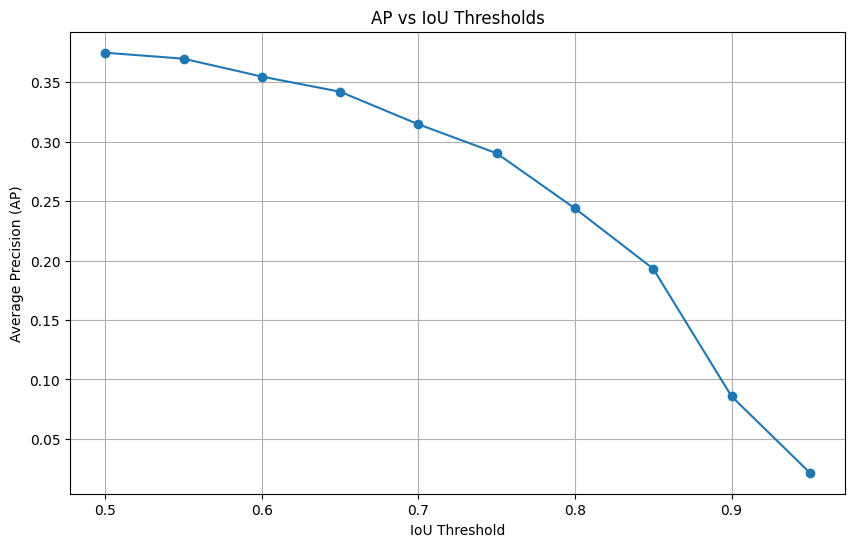

In [ ]:
iou_thresholds = np.arange(0.5, 1.0, 0.05)
mean_aps = compute_ap_for_thresholds(vgg16_model, test_loader, device, iou_thresholds)
plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, mean_aps, marker='o')
plt.title('AP vs IoU Thresholds')
plt.xlabel('IoU Threshold')
plt.ylabel('Average Precision (AP)')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


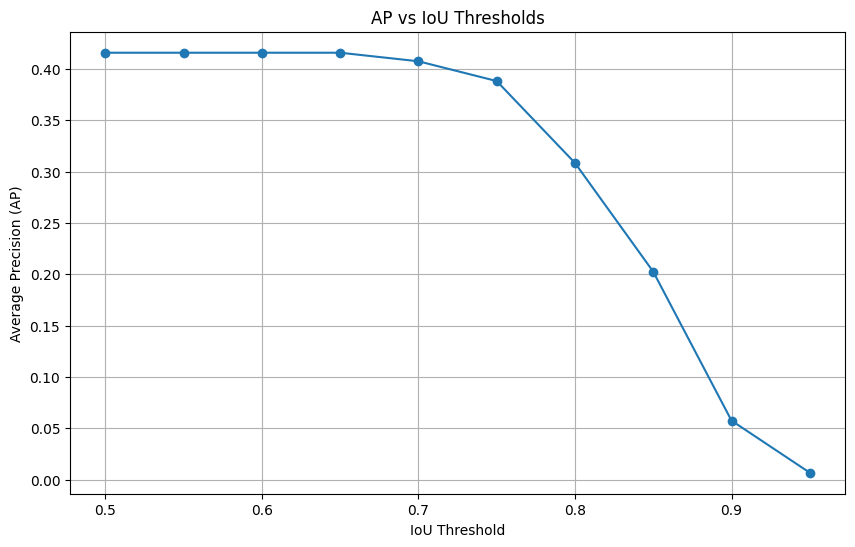

In [ ]:
mean_aps = compute_ap_for_thresholds(faster_rcnn_model, test_loader, device, iou_thresholds)
plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, mean_aps, marker='o')
plt.title('AP vs IoU Thresholds')
plt.xlabel('IoU Threshold')
plt.ylabel('Average Precision (AP)')
plt.grid(True)
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.ops import box_iou
import numpy as np

def compute_ap_for_thresholds_per_class(model, data_loader, device, iou_thresholds, num_classes):
    model.eval()
    ap_results_per_class = {class_id: [] for class_id in range(num_classes)}

    with torch.no_grad():
        for iou_threshold in iou_thresholds:
            ap_per_class = {class_id: [] for class_id in range(num_classes)}
            for images, targets in data_loader:
                images = list(img.to(device) for img in images)
                outputs = model(images)

                for output, target in zip(outputs, targets):
                    pred_boxes = output['boxes'].cpu()
                    pred_labels = output['labels'].cpu()
                    pred_scores = output['scores'].cpu()
                    true_boxes = target['boxes'].cpu()
                    true_labels = target['labels'].cpu()

                    if len(true_boxes) == 0:
                        continue

                    for class_id in range(num_classes):
                        class_pred_boxes = pred_boxes[pred_labels == class_id]
                        class_pred_scores = pred_scores[pred_labels == class_id]
                        class_true_boxes = true_boxes[true_labels == class_id]

                        if len(class_true_boxes) == 0 or len(class_pred_boxes) == 0:
                            continue

                        ious = box_iou(class_pred_boxes, class_true_boxes)
                        if ious.numel() == 0:
                            continue

                        preds_sorted_idx = class_pred_scores.sort(descending=True).indices
                        ap = compute_ap(ious, preds_sorted_idx, iou_threshold)
                        ap_per_class[class_id].append(ap)

            mean_ap_per_class = {class_id: sum(aps) / len(aps) if aps else 0 for class_id, aps in ap_per_class.items()}
            for class_id, mean_ap in mean_ap_per_class.items():
                ap_results_per_class[class_id].append(mean_ap)

    return ap_results_per_class

iou_thresholds = np.arange(0.5, 1.0, 0.05)

id_to_class_label=['prohibitory', 'danger', 'mandatory', 'other', 'background']


In [ ]:
ap_results_per_class = compute_ap_for_thresholds_per_class(trained_vgg16, test_loader, device, iou_thresholds, 5)
plt.figure(figsize=(14, 10))
for class_id in range(5):
    plt.plot(iou_thresholds, ap_results_per_class[class_id], marker='o', label=f'Class {id_to_class_label[class_id]}')

plt.title('AP vs IoU Thresholds for Each Class')
plt.xlabel('IoU Threshold')
plt.ylabel('Average Precision (AP)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ap_results_per_class = compute_ap_for_thresholds_per_class(trained_faster_rcnn, test_loader, device, iou_thresholds, 5)
plt.figure(figsize=(14, 10))
for class_id in range(5):
    plt.plot(iou_thresholds, ap_results_per_class[class_id], marker='o', label=f'Class {id_to_class_label[class_id]}')

plt.title('AP vs IoU Thresholds for Each Class')
plt.xlabel('IoU Threshold')
plt.ylabel('Average Precision (AP)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import numpy as np
from torchvision.ops import box_iou

def evaluate_model_per_size(model, data_loader, device, iou_thresholds):
    model.eval()
    ap_results_per_size = {label: [] for label in size_label.values()}

    with torch.no_grad():
        for iou_threshold in iou_thresholds:
            ap_per_size = {label: [] for label in size_label.values()}
            for images, targets in data_loader:
                images = list(img.to(device) for img in images)
                outputs = model(images)

                for output, target in zip(outputs, targets):
                    pred_boxes = output['boxes'].cpu()
                    pred_scores = output['scores'].cpu()
                    true_boxes = target['boxes'].cpu()

                    if len(true_boxes) == 0:
                        continue

                    for size in size_label.values():
                        class_pred_boxes = pred_boxes[[width_to_size_label((box[2] - box[0]).item()) == size for box in pred_boxes]]
                        class_pred_scores = pred_scores[[width_to_size_label((box[2] - box[0]).item()) == size for box in pred_boxes]]
                        class_true_boxes = true_boxes[[width_to_size_label((box[2] - box[0]).item()) == size for box in true_boxes]]

                        if len(class_true_boxes) == 0 or len(class_pred_boxes) == 0:
                            continue

                        ious = box_iou(class_pred_boxes, class_true_boxes)
                        if ious.numel() == 0:
                            continue

                        preds_sorted_idx = class_pred_scores.sort(descending=True).indices
                        ap = compute_ap(ious, preds_sorted_idx, iou_threshold)
                        ap_per_size[size].append(ap)

            mean_ap_per_size = {size: sum(aps) / len(aps) if aps else 0 for size, aps in ap_per_size.items()}
            for size, mean_ap in mean_ap_per_size.items():
                ap_results_per_size[size].append(mean_ap)

    return ap_results_per_size

In [ ]:
iou_thresholds = np.arange(0.5, 1.0, 0.05)

ap_results_per_size = evaluate_model_per_size(trained_vgg16, test_loader, iou_thresholds)

plt.figure(figsize=(14, 10))
for size in size_label.values():
    plt.plot(iou_thresholds, ap_results_per_size[size], marker='o', label=f'Size: {size}')

plt.title('AP vs IoU Thresholds for Each Size Category')
plt.xlabel('IoU Threshold')
plt.ylabel('Average Precision (AP)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
iou_thresholds = np.arange(0.5, 1.0, 0.05)

ap_results_per_size = evaluate_model_per_size(trained_faster_rcnn, test_loader, iou_thresholds)

plt.figure(figsize=(14, 10))
for size in size_label.values():
    plt.plot(iou_thresholds, ap_results_per_size[size], marker='o', label=f'Size: {size}')

plt.title('AP vs IoU Thresholds for Each Size Category')
plt.xlabel('IoU Threshold')
plt.ylabel('Average Precision (AP)')
plt.legend()
plt.grid(True)
plt.show()